# 6d reconstruction scan

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## define the diagnostic

In [2]:
import pandas as pd

from plugins.interfaces.diagnostics import EPICSImageDiagnostic, ROI

screen_name = "13ARV1"
save_image_location = "../run_data/2023_11_17/"
TESTING = True
DYG14_IP = 1
DYG15_IP = 2
charge_pvs = []

dyg14_roi = ROI(
    xmin=0, xmax=2000, ymin=0, ymax=2000
)
dyg15_roi = ROI(
    xmin=0, xmax=2000, ymin=0, ymax=2000
)

DYG14 = EPICSImageDiagnostic(
    screen_name=screen_name,
    resolution_suffix=None,
    roi=dyg14_roi,
    extra_pvs=charge_pvs,
    save_image_location=save_image_location,
    testing=TESTING
)

DYG15 = EPICSImageDiagnostic(
    screen_name=screen_name,
    resolution_suffix=None,
    roi=dyg15_roi,
    extra_pvs=charge_pvs,
    save_image_location=save_image_location,
    testing=TESTING
)

def set_camera(ip_address, testing=False):
    if not testing:
        from epics import caput
        # stop the current camera
        caput("13ARV1:cam1:Acquire", 0)
        # set the new camera IP address
        caput("13ARV1:cam1:SetCameraIP", ip_address)
        # start the new camera
        caput("13ARV1:cam1:Acquire", 1)



fitting image


{'Cx': 999.499997296439,
 'Cy': 999.4999943116106,
 'Sx': 71.88859467142711,
 'Sy': 145.10874605364663,
 'bb_penalty': -513.5103678646803,
 'total_intensity': 80000.0,
 'log10_total_intensity': 4.903089986991944,
 'ICT1': 0.29866086938924574,
 'ICT2': 0.24597371674792945}

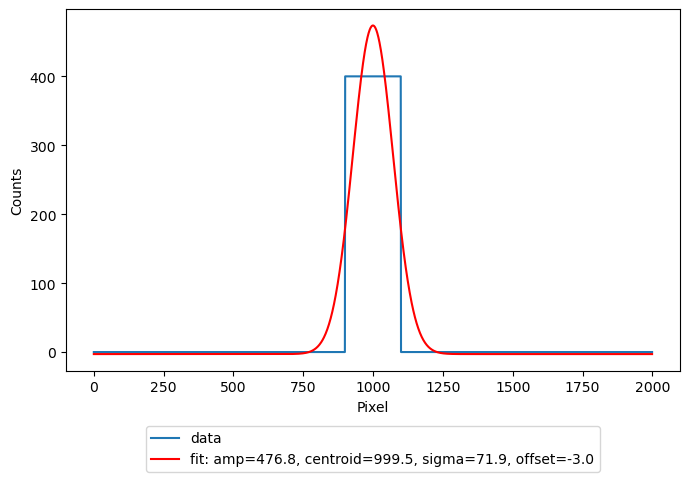

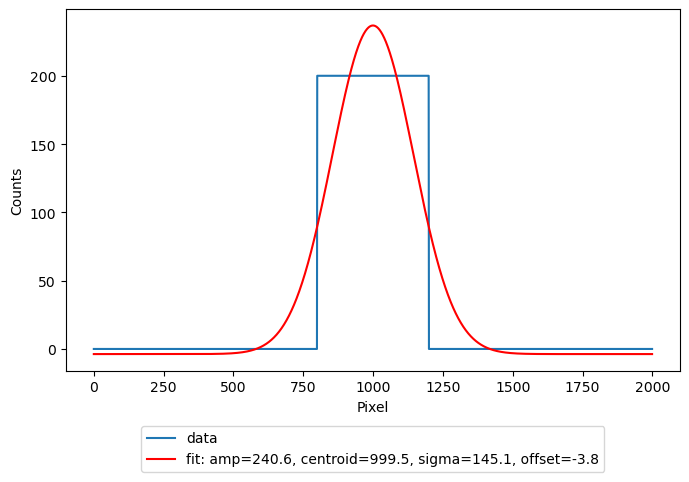

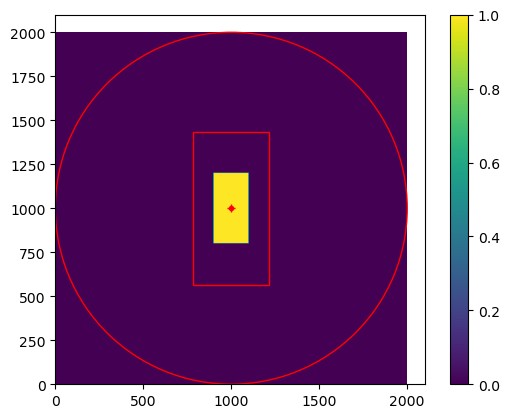

In [3]:
set_camera(DYG14_IP, testing=TESTING)
DYG14.test_measurement()

fitting image


{'Cx': 999.499945145097,
 'Cy': 999.5000352073549,
 'Sx': 71.8886793427833,
 'Sy': 145.1084925168634,
 'bb_penalty': -513.5109498600325,
 'total_intensity': 80000.0,
 'log10_total_intensity': 4.903089986991944,
 'ICT1': 0.9743009120235469,
 'ICT2': 1.3337786588132192}

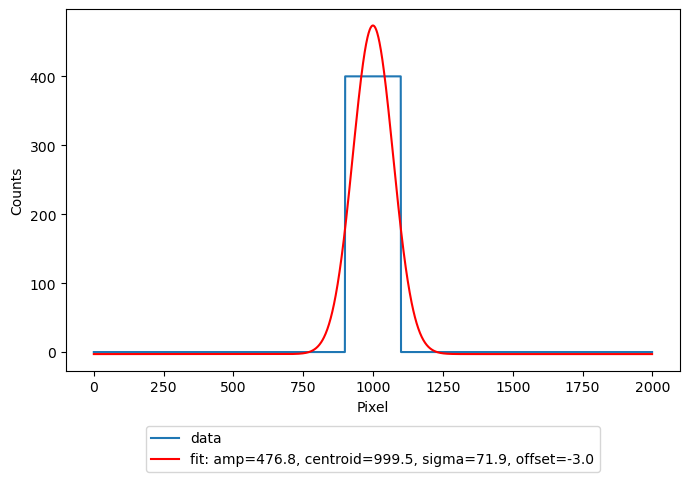

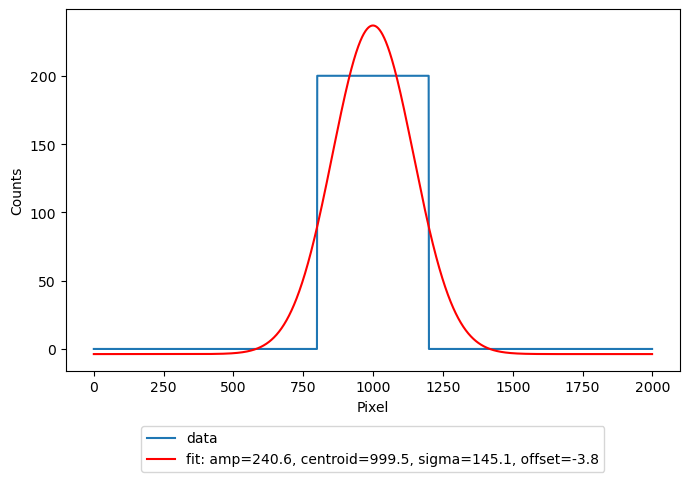

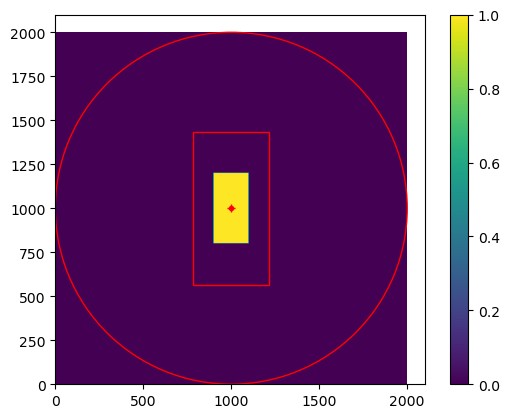

In [4]:
set_camera(DYG15_IP, testing=TESTING)
DYG15.test_measurement()

### Define the evaluator

In [5]:
from epics import caput, caget
from xopt import Evaluator
import time
import numpy as np

def evaluate_function(inputs: dict, diagnostic, testing=False) -> dict:
    # caput values
    if not testing:
        for name, val in inputs:
            caput(name, val)

    # wait for changes to occur
    time.sleep(2)

    results = diagnostic.measure_beamsize(10, fit_image=False, **inputs)

    return results | inputs

evaluator = Evaluator(function=evaluate_function)

### Set up scan

In [6]:
# quad strength pv values
x = np.linspace(0,10,5)
quad_pv_name = "quad_pv_name"
tdc_pv_name = "tdc_name"
dipole_pv_name = "dipole_name"
tdc_vals = {"OFF":0, "ON":1} # off/on values
dipole_vals = {"OFF":0, "ON":2} # off/on vals

def do_quad_scan(k, pv_dict, diagnostic, testing=False):
    q_scan_data = []
    print("doing quad scan")
    for ele in k:
        # add tcav/dipole settings to quad settings
        total_pvs = pv_dict | {quad_pv_name:ele}
        print(total_pvs)

        # do measurement
        result = evaluate_function(total_pvs, diagnostic, testing)
        q_scan_data += [result]

    return q_scan_data

data = []

# do quad scan with dipole off
set_camera(DYG14_IP, testing=TESTING)
for tdc_state in ["OFF","ON"]:
    q_scan_results = do_quad_scan(
        x,
        {tdc_pv_name: tdc_vals[tdc_state], dipole_pv_name: dipole_vals["OFF"]},
        DYG14,
        TESTING
    )
    data = data + q_scan_results

# do quad scan with dipole on
set_camera(DYG15_IP, testing=TESTING)
for tdc_state in ["OFF","ON"]:
    q_scan_results = do_quad_scan(
        x,
        {tdc_pv_name: tdc_vals[tdc_state], dipole_pv_name: dipole_vals["ON"]},
        DYG14,
        TESTING
    )
    data = data + q_scan_results

data = pd.DataFrame(data)


doing quad scan
{'tdc_name': 0, 'dipole_name': 0, 'quad_pv_name': 0.0}
{'tdc_name': 0, 'dipole_name': 0, 'quad_pv_name': 2.5}
{'tdc_name': 0, 'dipole_name': 0, 'quad_pv_name': 5.0}
{'tdc_name': 0, 'dipole_name': 0, 'quad_pv_name': 7.5}
{'tdc_name': 0, 'dipole_name': 0, 'quad_pv_name': 10.0}
doing quad scan
{'tdc_name': 1, 'dipole_name': 0, 'quad_pv_name': 0.0}
{'tdc_name': 1, 'dipole_name': 0, 'quad_pv_name': 2.5}
{'tdc_name': 1, 'dipole_name': 0, 'quad_pv_name': 5.0}
{'tdc_name': 1, 'dipole_name': 0, 'quad_pv_name': 7.5}
{'tdc_name': 1, 'dipole_name': 0, 'quad_pv_name': 10.0}
doing quad scan
{'tdc_name': 0, 'dipole_name': 2, 'quad_pv_name': 0.0}
{'tdc_name': 0, 'dipole_name': 2, 'quad_pv_name': 2.5}
{'tdc_name': 0, 'dipole_name': 2, 'quad_pv_name': 5.0}
{'tdc_name': 0, 'dipole_name': 2, 'quad_pv_name': 7.5}
{'tdc_name': 0, 'dipole_name': 2, 'quad_pv_name': 10.0}
doing quad scan
{'tdc_name': 1, 'dipole_name': 2, 'quad_pv_name': 0.0}
{'tdc_name': 1, 'dipole_name': 2, 'quad_pv_name': 2.5

In [7]:
import yaml
import json

# save dataframe to file
with open(os.path.join(save_image_location, 'data.yml'), 'w') as outfile:
    yaml.dump(json.loads(data.to_json(orient="records"))
, outfile, default_flow_style=False)